In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import(
    load_excel, 
    load_odin_as_ml_dataset, 
    plot_confusion_matrix, 
    make_ml_dataset, 
    run_binary_regression, 
    transport_modes, 
    trip_motives, 
    province_codes, 
    transport_mode_col, 
    IGNORE_RULES, 
    apply_ignore_rules,
    number_of_sub_trips_col,
    id_col
    )

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
years = [2019, 2021, 2022, 2023]
dfs = []
for year in years:
    odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
    if year in [2019, 2020]:
        odin_excel_path = odin_excel_path.replace("Databestand", "Databestand_v2.0")
    df = load_excel(odin_excel_path)
    # df = apply_ignore_rules(df, IGNORE_RULES)   # <<–– new line

    dfs.append(df[df[number_of_sub_trips_col] == 1])  # Filter for single sub-trips

df_all = pd.concat(dfs, ignore_index=True, join="inner")

Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV


In [3]:
df_all.columns

Index(['OP', 'OPID', 'Steekproef', 'Mode', 'HHPers', 'HHSam', 'HHPlOP',
       'HHLft1', 'HHLft2', 'HHLft3',
       ...
       'RReisduur', 'RReisduurBL', 'RVertStat', 'RAankStat', 'RTSamen',
       'RCorrSnelh', 'RVliegVer', 'FactorH', 'FactorP', 'FactorV'],
      dtype='object', length=202)

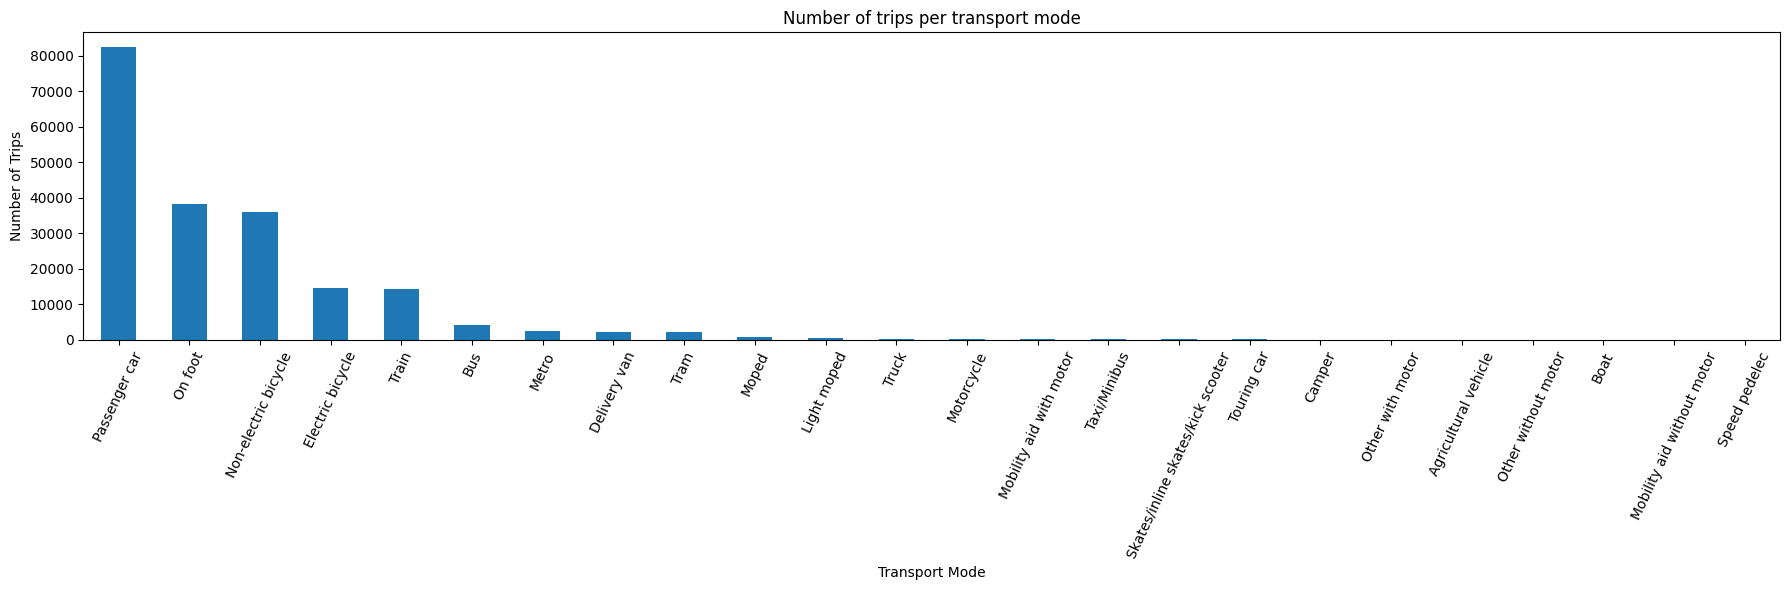

In [4]:
# Create a histogram for the number of trips for each transport mode and translate to 
ax = df[transport_mode_col].value_counts().plot(kind="bar", title="Number of trips per transport mode", figsize=(18, 6))

ax.set_xticklabels([transport_modes.get(int(float(label.get_text())), label.get_text()) for label in ax.get_xticklabels()], rotation=65)

plt.xlabel("Transport Mode")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.savefig("graphics/transport_modes_histogram.png", dpi=300)
plt.show()

Now a classifier that classifies what mode of transport was used

Common labels: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23.]


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.2s finished


                                   precision    recall  f1-score   support

                    Passenger car       0.82      0.26      0.40     57982
                            Train       0.12      0.77      0.20       264
                              Bus       0.15      0.59      0.25       553
                             Tram       0.14      0.73      0.24       301
                            Metro       0.05      0.26      0.09       172
                    Speed pedelec       0.00      0.00      0.00         6
                 Electric bicycle       0.35      0.80      0.49      8652
             Non-electric bicycle       0.58      0.47      0.52     27304
                          On foot       0.86      0.37      0.51     28163
                      Touring car       0.02      0.10      0.04        94
                     Delivery van       0.11      0.47      0.18      1835
                            Truck       0.91      0.61      0.73       140
                        

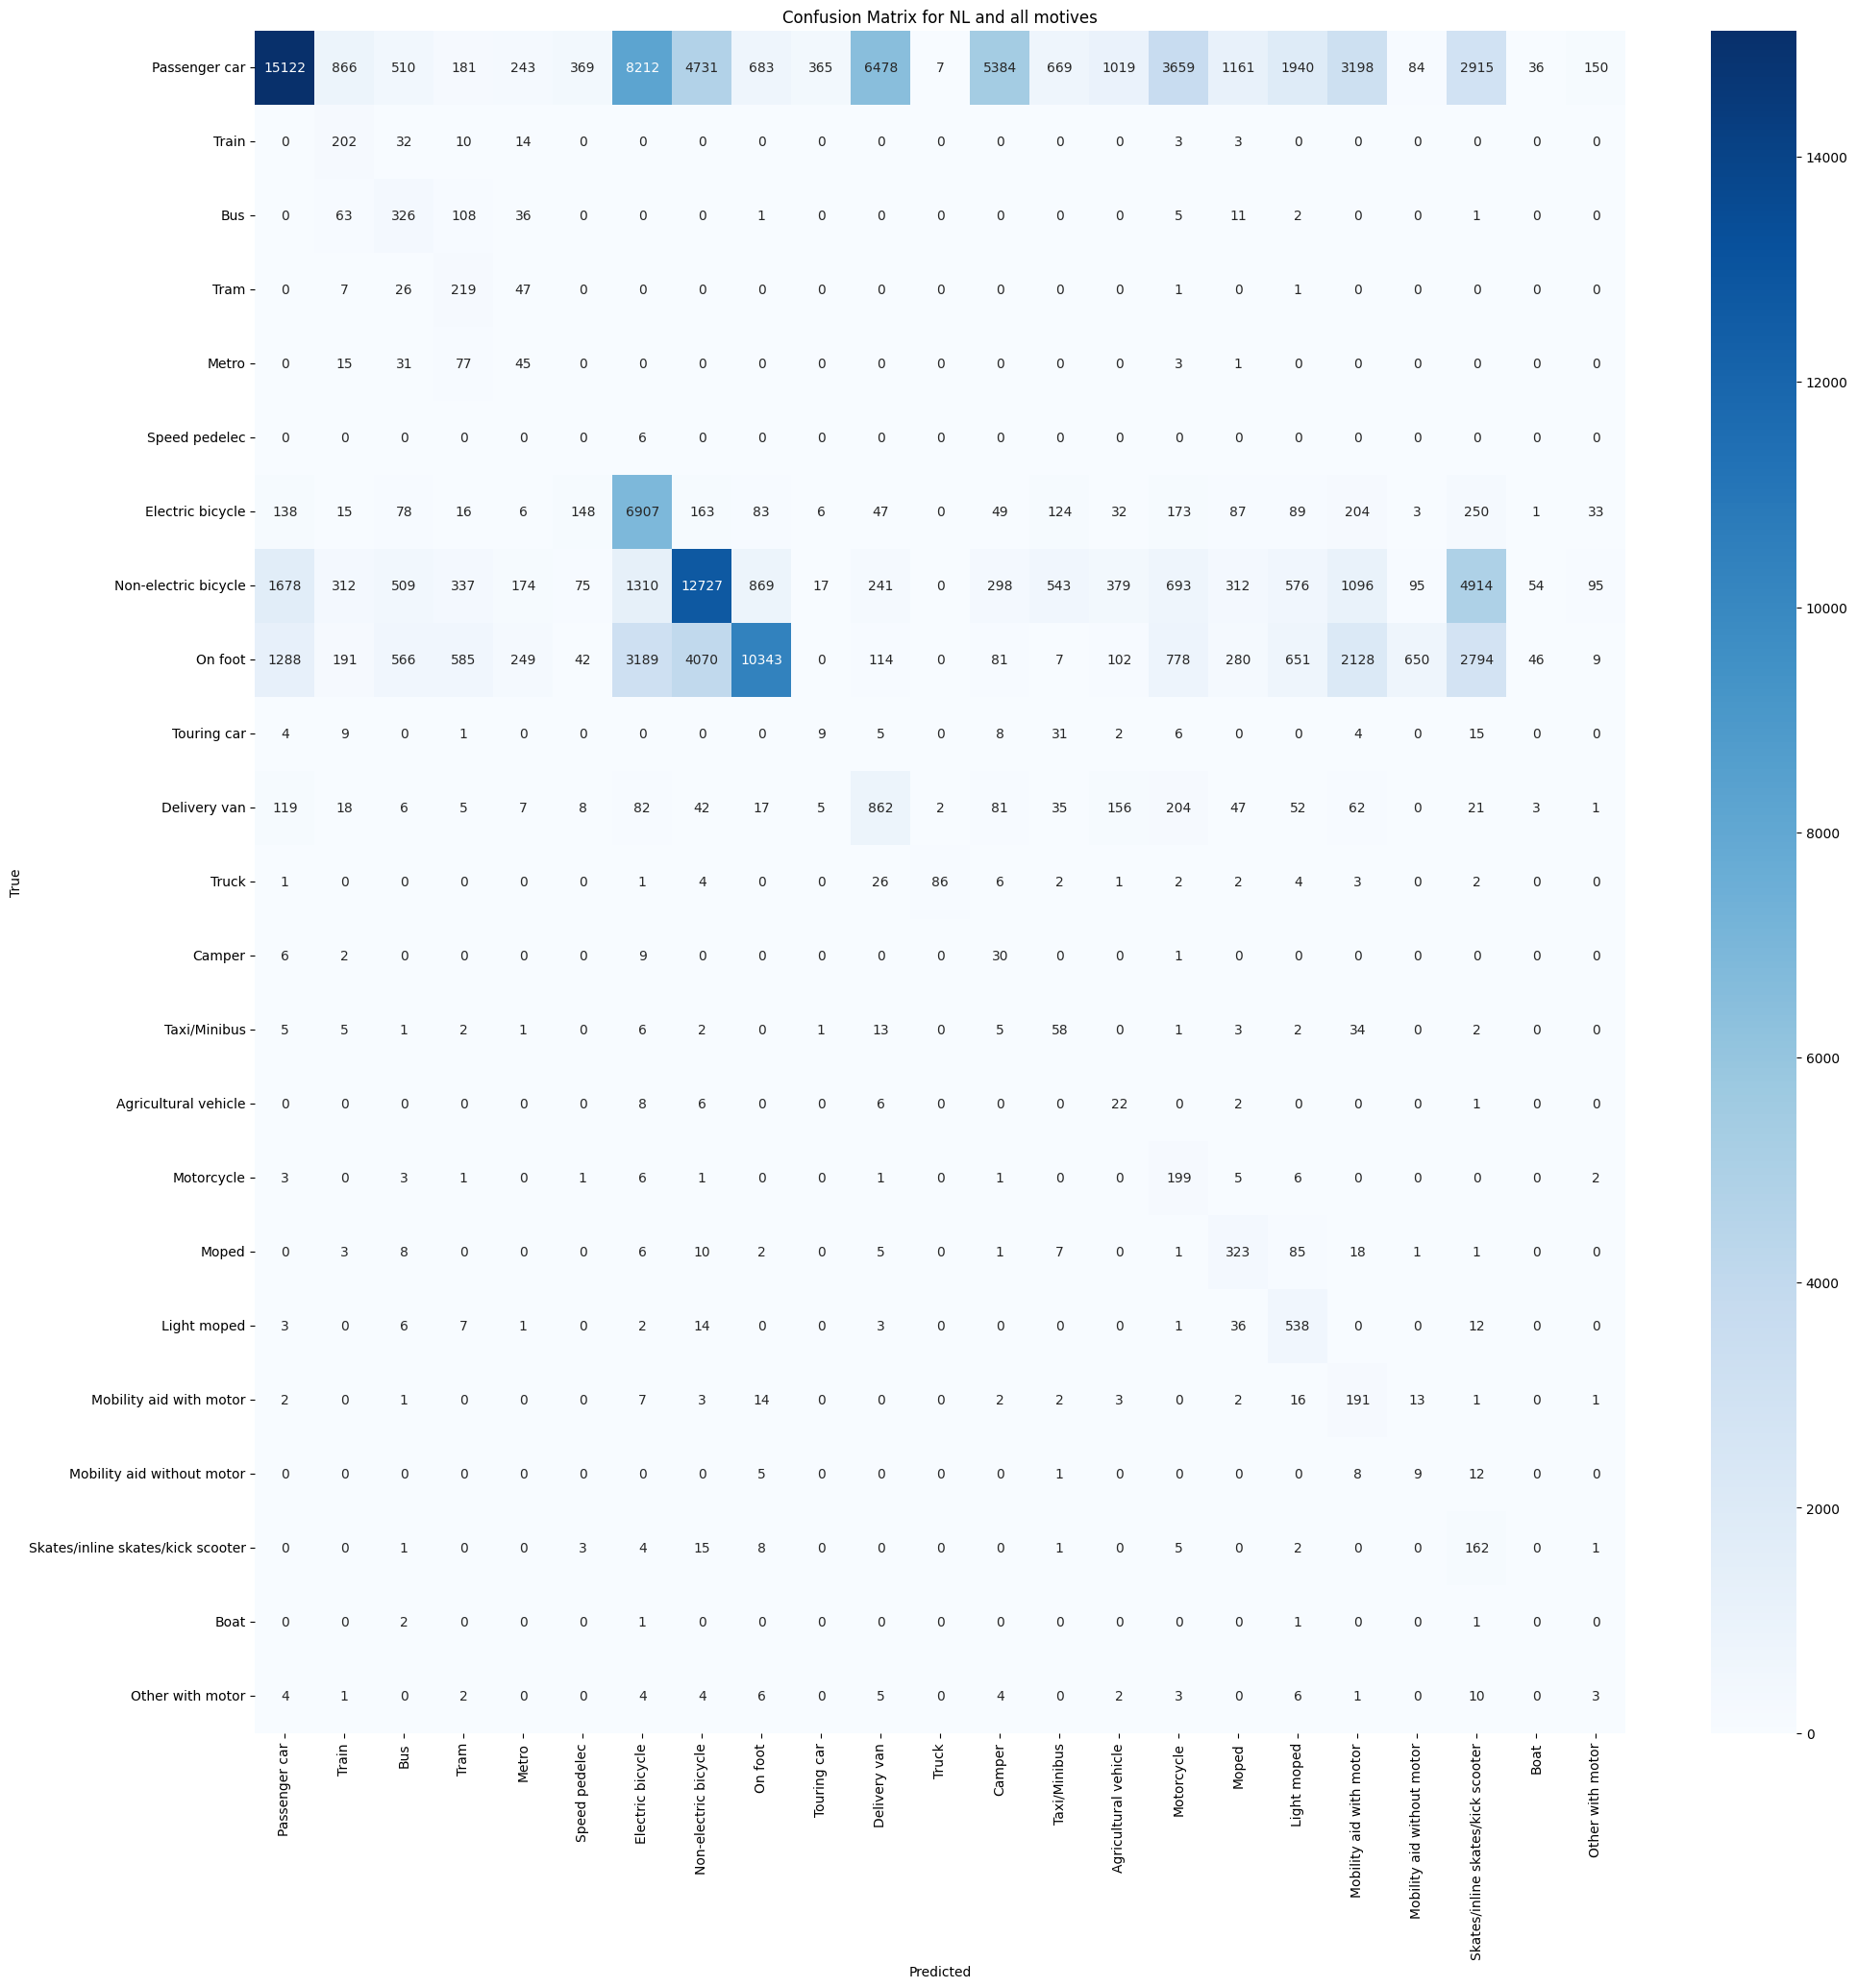

In [5]:
from codebase import (run_multiclass_classification,
                      distance_col, 
                      origin_col, 
                      province_codes, 
                      level_mapping_suffix, 
                      age_col, 
                      transport_mode_col, 
                      motive_col, 
                      urbanness_col,
                      categorical_cols)


df_multiclass = df_all[df_all[transport_mode_col] != df_all[transport_mode_col].max()]
motives=None
origins=None#[7, 8, ]
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_all, (X_train_all, _, _, _), accuracy = run_multiclass_classification(
    df_multiclass,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/full",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
    verbose=True,
)

In [18]:
def get_feature_importances(feature_importances, column_names, top_n_for_plot=100, savename=None):
    """
    Feature importances for multiclass classification.
    """
    importances = pd.Series(feature_importances, index=column_names)
    
    # Group by base feature name (e.g., col_1 from col_1.0, col_1.1)
    grouped = importances.groupby(lambda x: x.split('_')[0]).sum()
    top_features = grouped.sort_values(ascending=False)[:top_n_for_plot]
    num_features = len(grouped)
    num_plotted_features = min(num_features, top_n_for_plot)

    top_features.plot(kind="bar", figsize=(14, 6))
    plt.title(f"Top {num_plotted_features}/{num_features} Feature Importances for Multiclass Classification")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.xticks(rotation=65)
    if savename:
        plt.savefig(savename)
    plt.show()
    
    return grouped

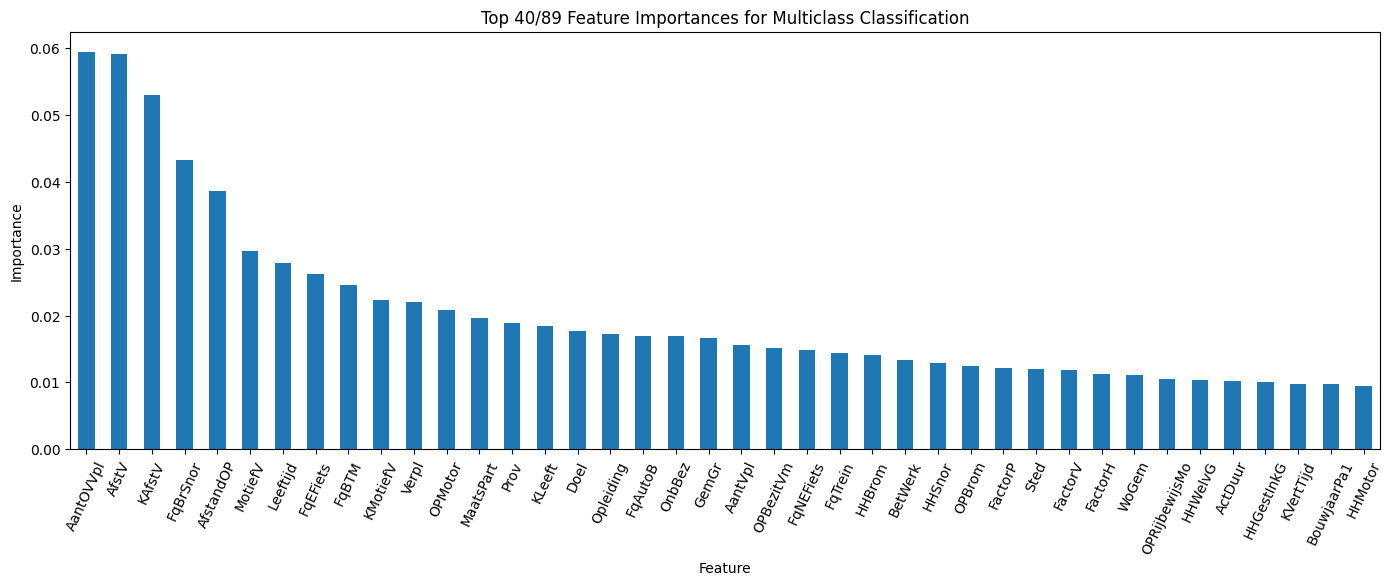

AantOVVpl     0.059477
AantSVpl      0.002985
AantVpl       0.015572
AardWerk      0.005636
ActDuur       0.010228
                ...   
Verpl         0.022061
VertLoc       0.007657
VolgWerk      0.004763
Weggeweest    0.000020
WoGem         0.011170
Length: 89, dtype: float64

In [19]:
get_feature_importances(pipeline_all.steps[1][1].feature_importances_, top_n_for_plot=40, column_names=X_train_all.columns, savename=f"graphics/classification_results/multiclass/feature_importances_all.png")

Common labels: [1. 7. 8. 9.]


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.73      0.80     57177
    Electric bicycle       0.41      0.88      0.56      8774
Non-electric bicycle       0.63      0.77      0.69     27030
             On foot       0.83      0.68      0.75     28067

            accuracy                           0.74    121048
           macro avg       0.69      0.77      0.70    121048
        weighted avg       0.79      0.74      0.75    121048



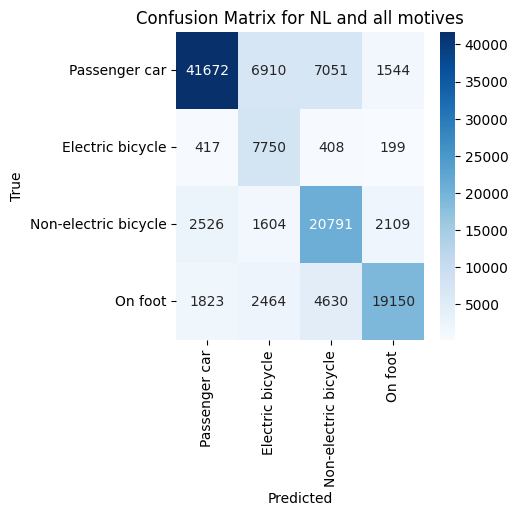

In [21]:
from codebase import urbanness_col, motive_col

age_range = (0, np.inf)
vehicles_to_include = [1, 7, 8, 9, ]

df_less_vehicles = df_multiclass[df_multiclass[transport_mode_col].isin(vehicles_to_include)]
df_less_vehicles: pd.DataFrame = df_less_vehicles[(df_less_vehicles[age_col] < age_range[1]) & (df_less_vehicles[age_col] > age_range[0])]

vehicles_to_include = [1, 7, 8, 9, ]

motives=None
origins=None#[7, 8, ]
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_less, (X_train_less, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

In [22]:
"AutoHhL" in X_train.columns

False

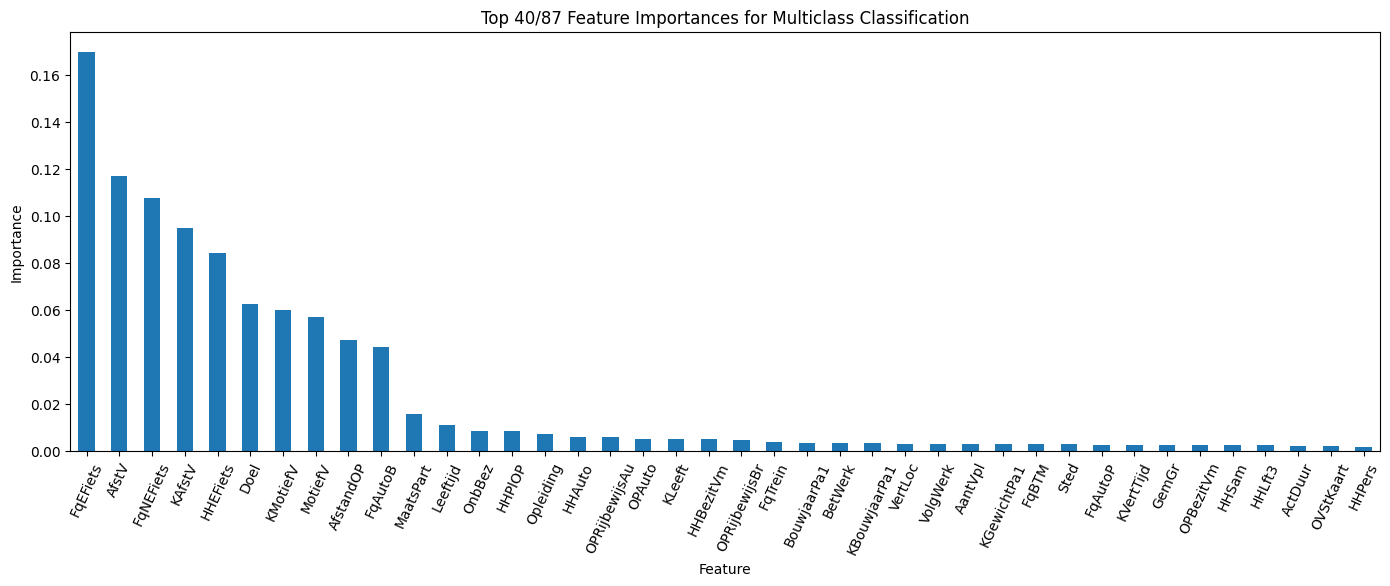

In [23]:
grouped_importances_less = get_feature_importances(pipeline_less.steps[1][1].feature_importances_, column_names=X_train_less.columns, top_n_for_plot=40, savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles.png")

In [24]:
"AutoHhl" in grouped_importances_less.index

False

Now keep the top 100

In [25]:
"Rvm" in df_less_vehicles.columns

True

Keeping 89 columns after dropping 113 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.73      0.80     57177
    Electric bicycle       0.41      0.88      0.56      8774
Non-electric bicycle       0.63      0.77      0.69     27030
             On foot       0.83      0.68      0.75     28067

            accuracy                           0.74    121048
           macro avg       0.69      0.77      0.70    121048
        weighted avg       0.79      0.74      0.75    121048



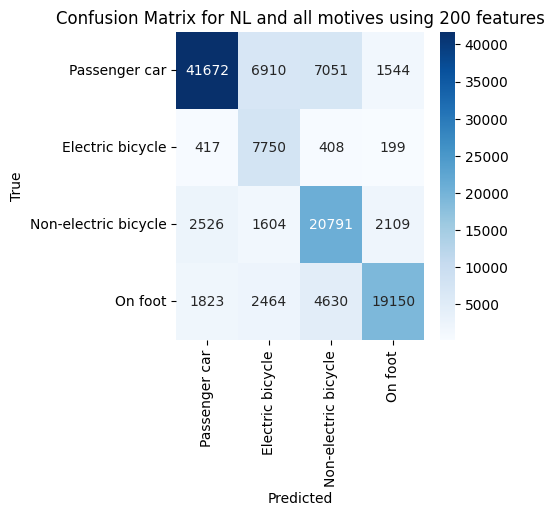

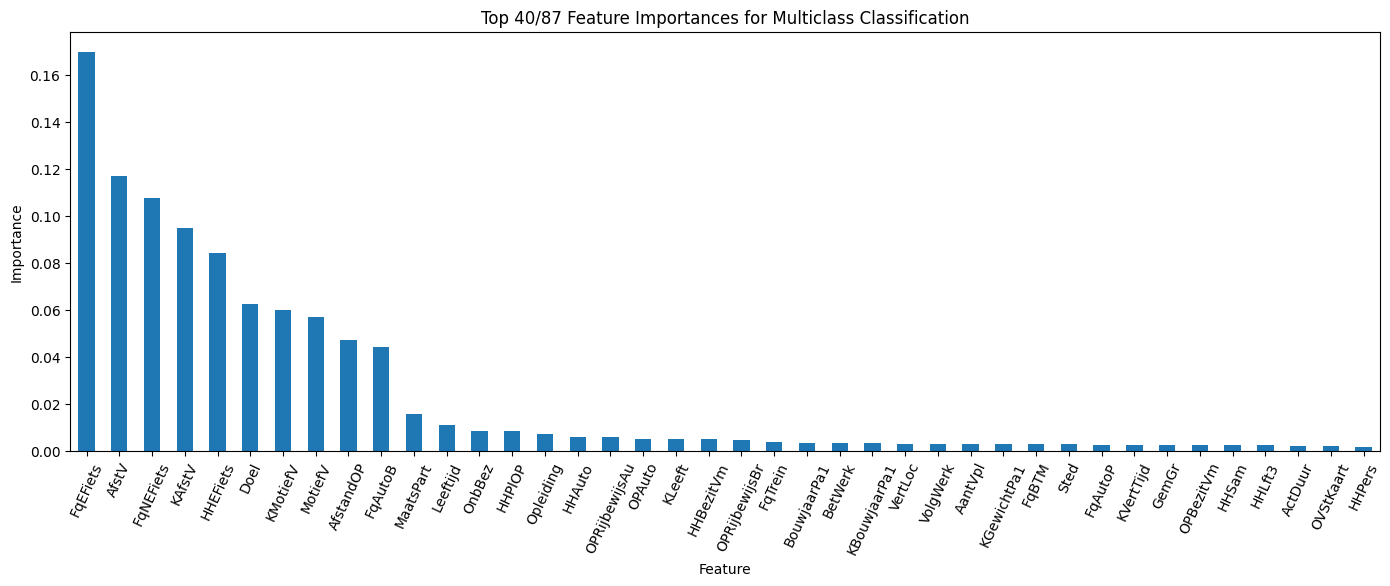

Keeping 89 columns after dropping 113 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.73      0.80     57177
    Electric bicycle       0.41      0.88      0.56      8774
Non-electric bicycle       0.63      0.77      0.69     27030
             On foot       0.83      0.68      0.75     28067

            accuracy                           0.74    121048
           macro avg       0.69      0.77      0.70    121048
        weighted avg       0.79      0.74      0.75    121048



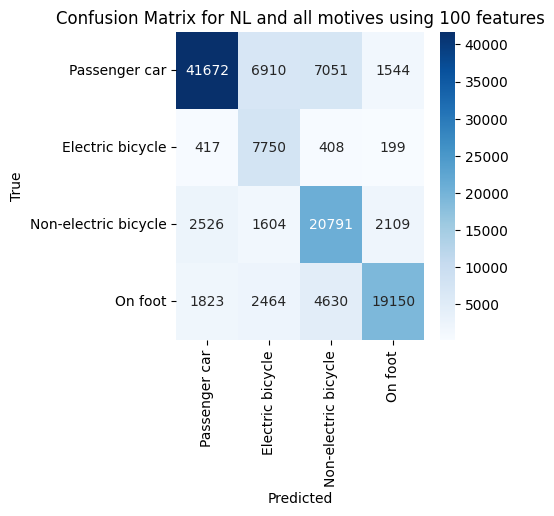

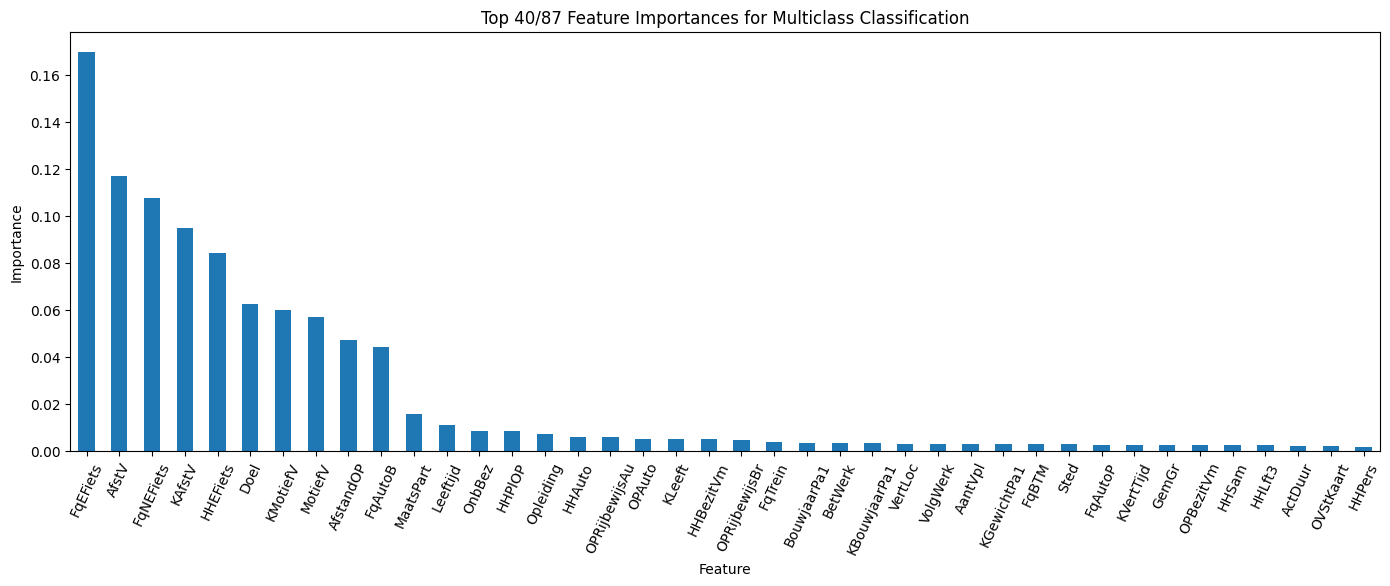

Keeping 52 columns after dropping 150 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.72      0.80     57177
    Electric bicycle       0.41      0.89      0.57      8774
Non-electric bicycle       0.63      0.77      0.70     27030
             On foot       0.83      0.69      0.76     28067

            accuracy                           0.74    121048
           macro avg       0.70      0.77      0.71    121048
        weighted avg       0.79      0.74      0.75    121048



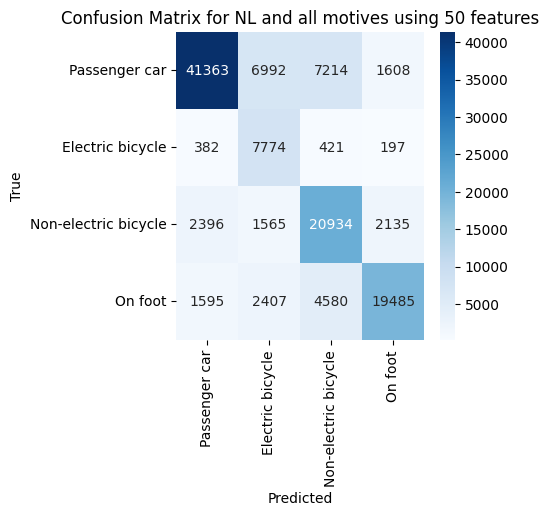

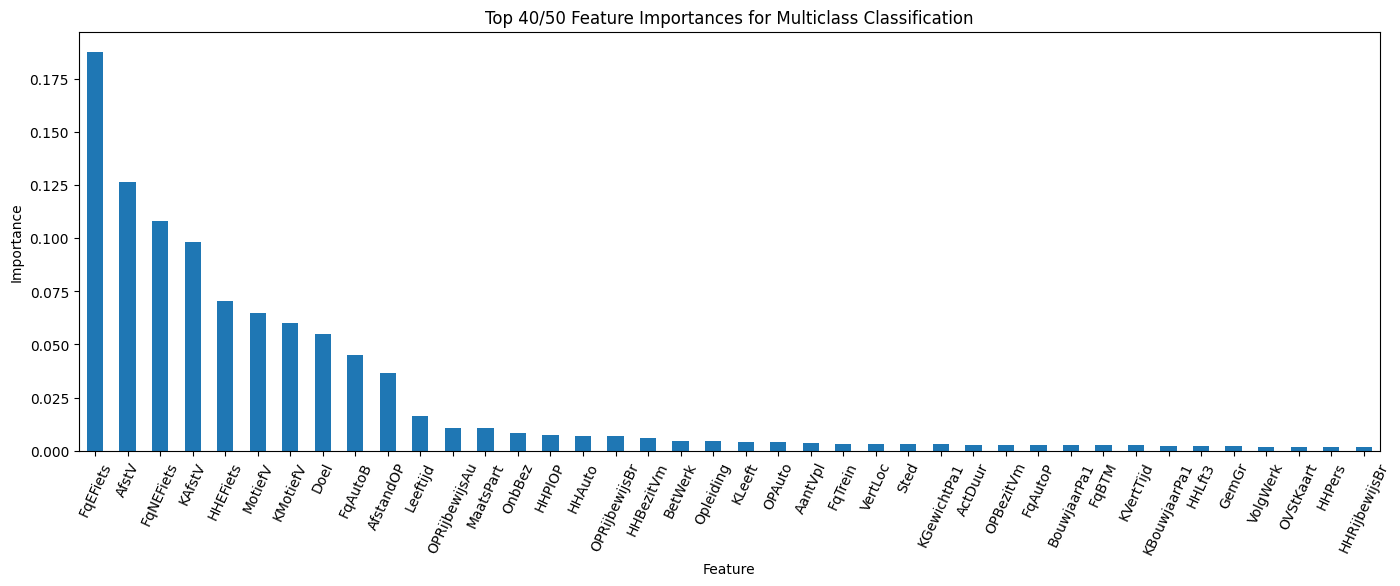

Keeping 27 columns after dropping 175 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.91      0.72      0.81     57177
    Electric bicycle       0.43      0.89      0.58      8774
Non-electric bicycle       0.63      0.78      0.70     27030
             On foot       0.83      0.71      0.76     28067

            accuracy                           0.75    121048
           macro avg       0.70      0.78      0.71    121048
        weighted avg       0.79      0.75      0.76    121048



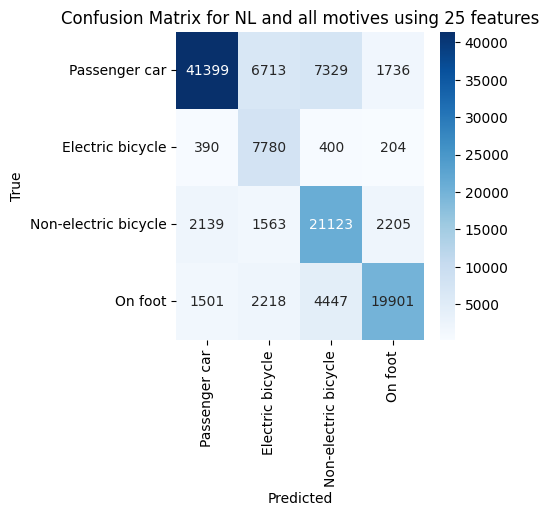

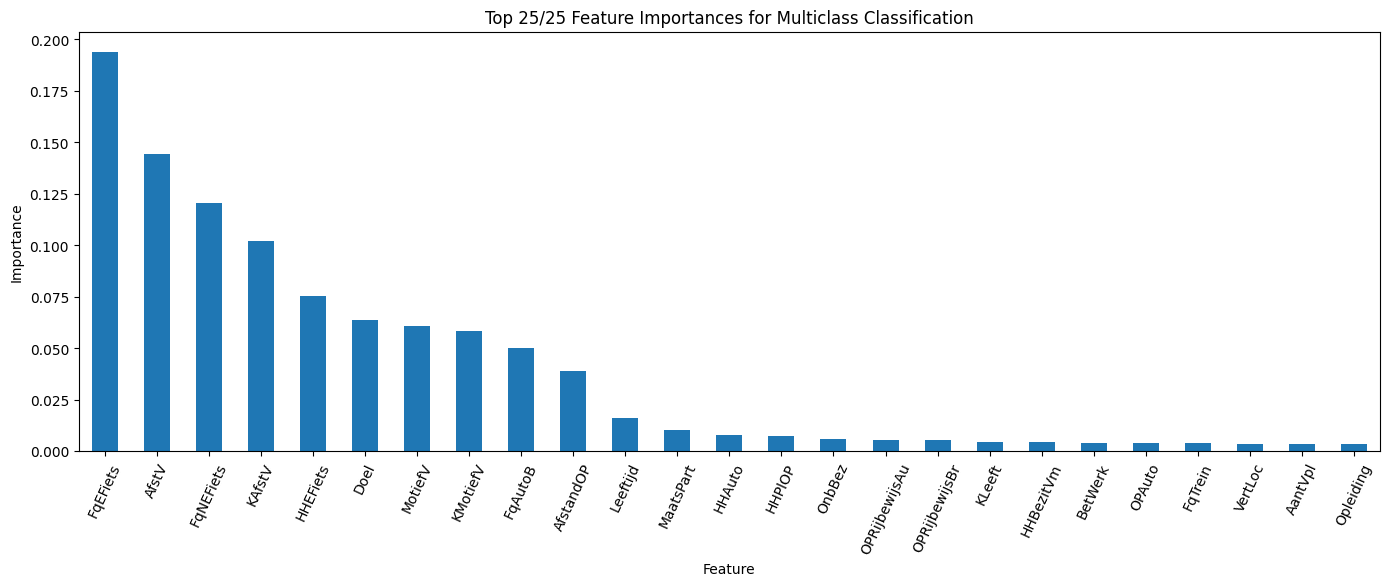

Keeping 17 columns after dropping 185 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.91      0.72      0.81     57177
    Electric bicycle       0.43      0.89      0.58      8774
Non-electric bicycle       0.64      0.78      0.70     27030
             On foot       0.83      0.72      0.77     28067

            accuracy                           0.75    121048
           macro avg       0.70      0.78      0.71    121048
        weighted avg       0.80      0.75      0.76    121048



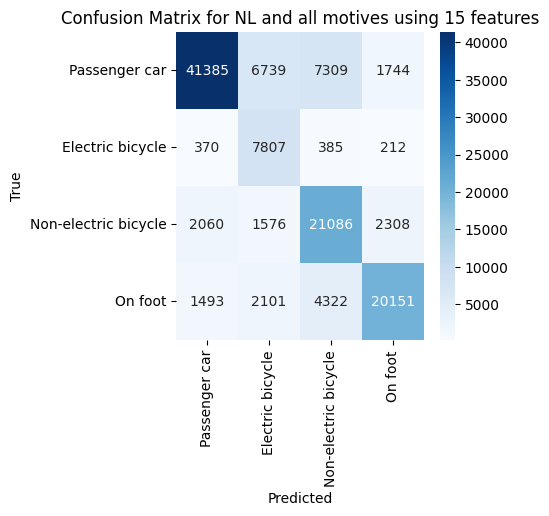

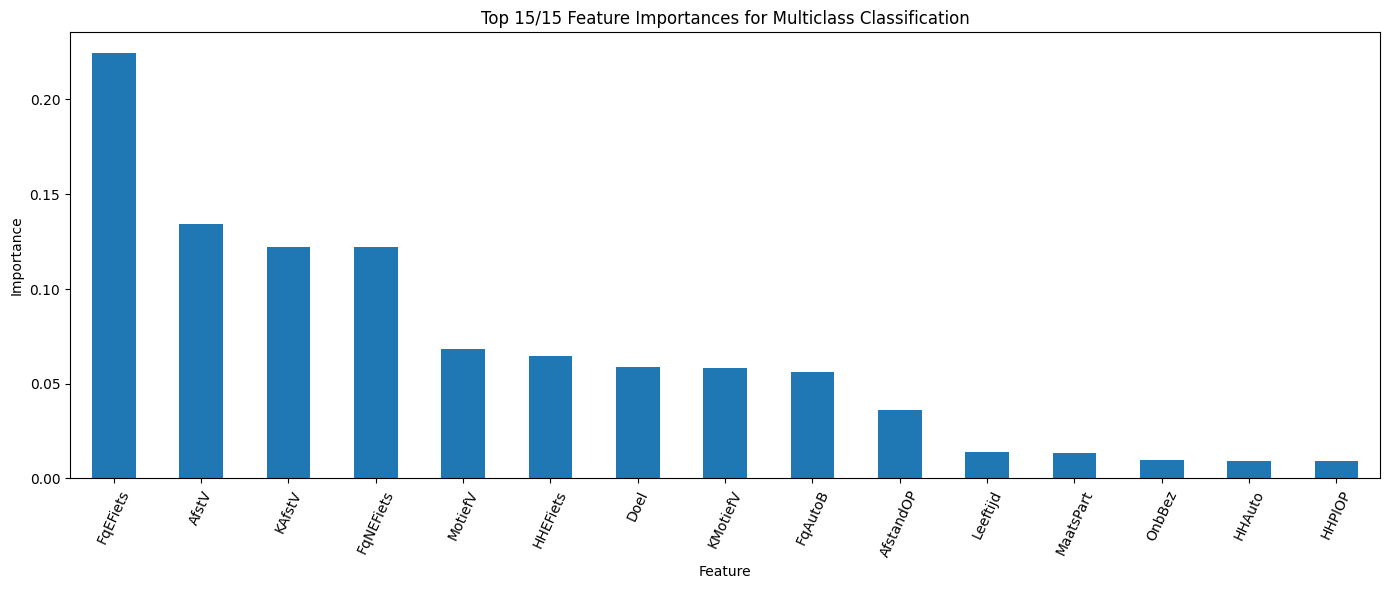

Keeping 12 columns after dropping 190 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.91      0.72      0.81     57177
    Electric bicycle       0.44      0.88      0.59      8774
Non-electric bicycle       0.64      0.78      0.70     27030
             On foot       0.82      0.72      0.77     28067

            accuracy                           0.75    121048
           macro avg       0.70      0.78      0.72    121048
        weighted avg       0.80      0.75      0.76    121048



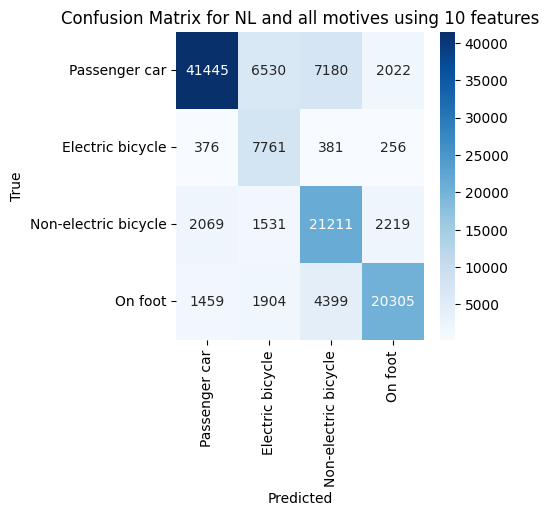

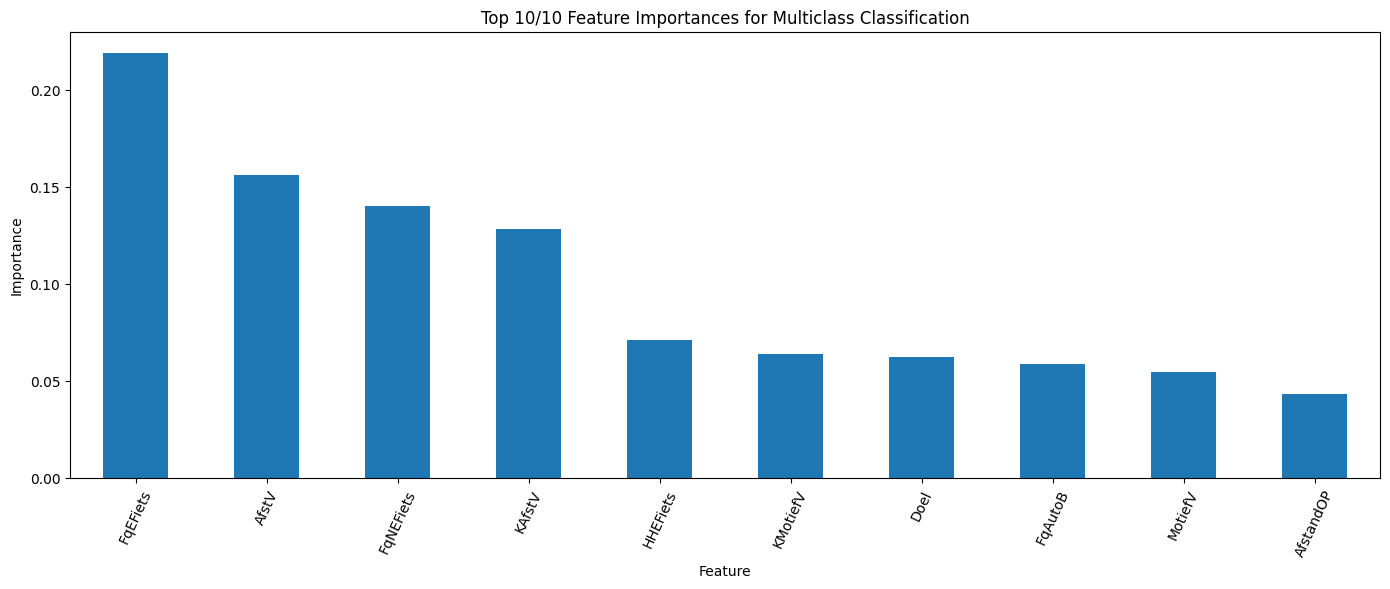

Keeping 10 columns after dropping 192 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.91      0.72      0.81     57177
    Electric bicycle       0.44      0.88      0.59      8774
Non-electric bicycle       0.65      0.78      0.71     27030
             On foot       0.81      0.73      0.77     28067

            accuracy                           0.75    121048
           macro avg       0.70      0.78      0.72    121048
        weighted avg       0.79      0.75      0.76    121048



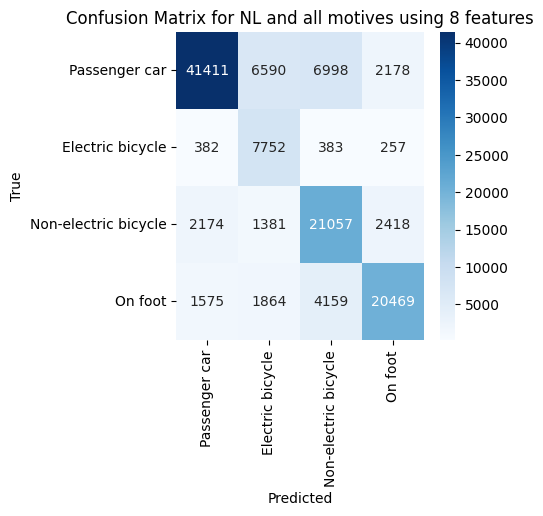

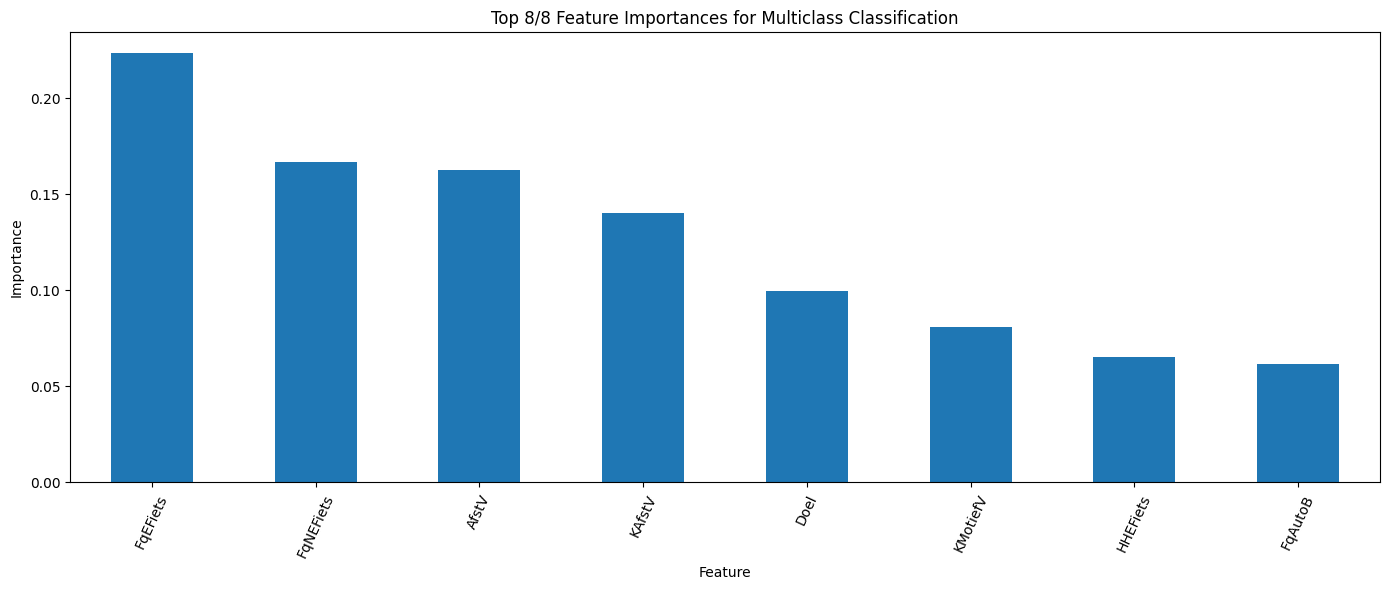

Keeping 7 columns after dropping 195 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.69      0.78     57177
    Electric bicycle       0.43      0.88      0.58      8774
Non-electric bicycle       0.63      0.78      0.70     27030
             On foot       0.79      0.72      0.75     28067

            accuracy                           0.73    121048
           macro avg       0.69      0.77      0.70    121048
        weighted avg       0.78      0.73      0.74    121048



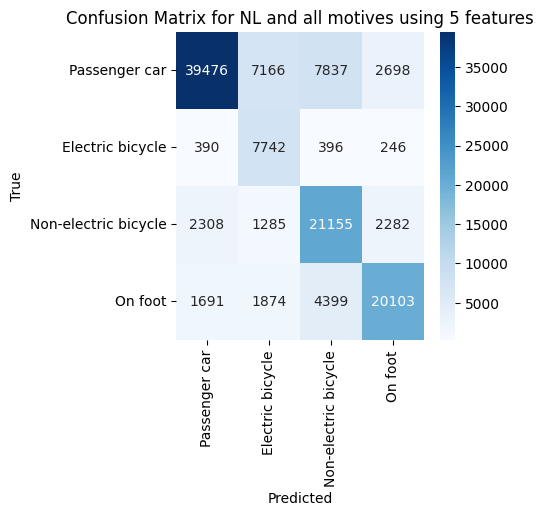

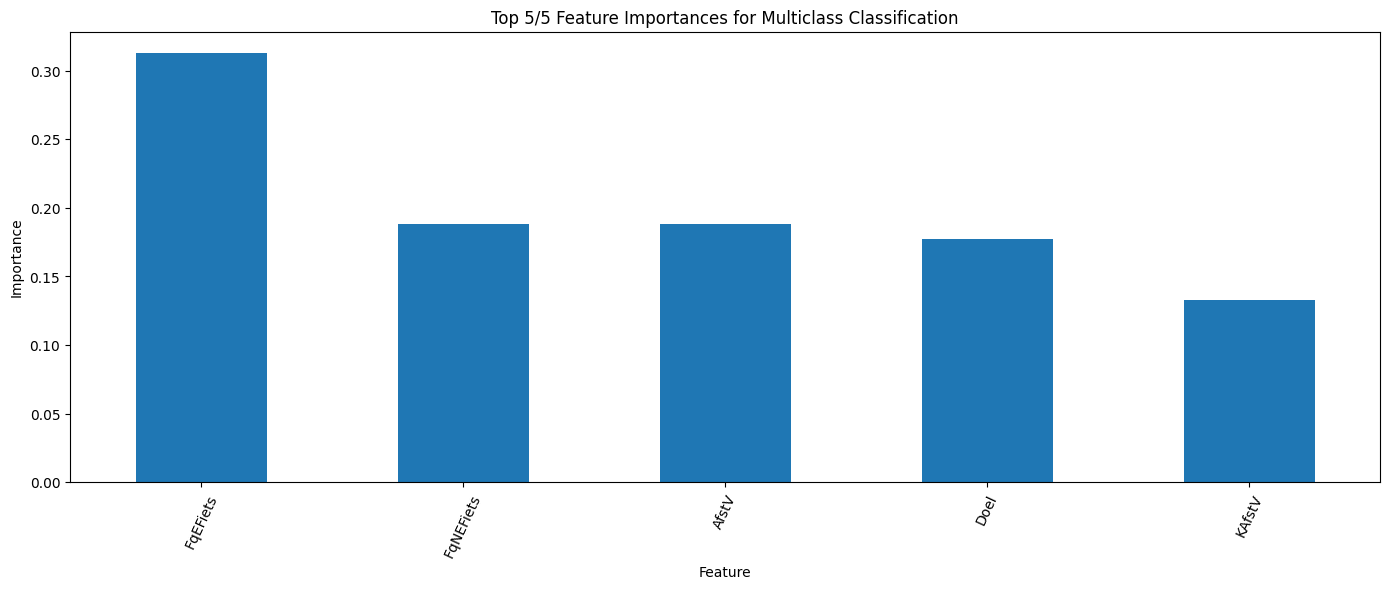

Keeping 6 columns after dropping 196 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.91      0.68      0.78     57177
    Electric bicycle       0.42      0.88      0.57      8774
Non-electric bicycle       0.63      0.78      0.70     27030
             On foot       0.77      0.73      0.75     28067

            accuracy                           0.73    121048
           macro avg       0.68      0.77      0.70    121048
        weighted avg       0.78      0.73      0.74    121048



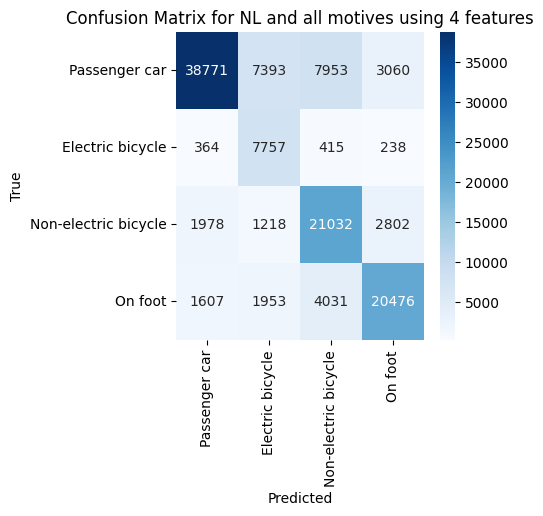

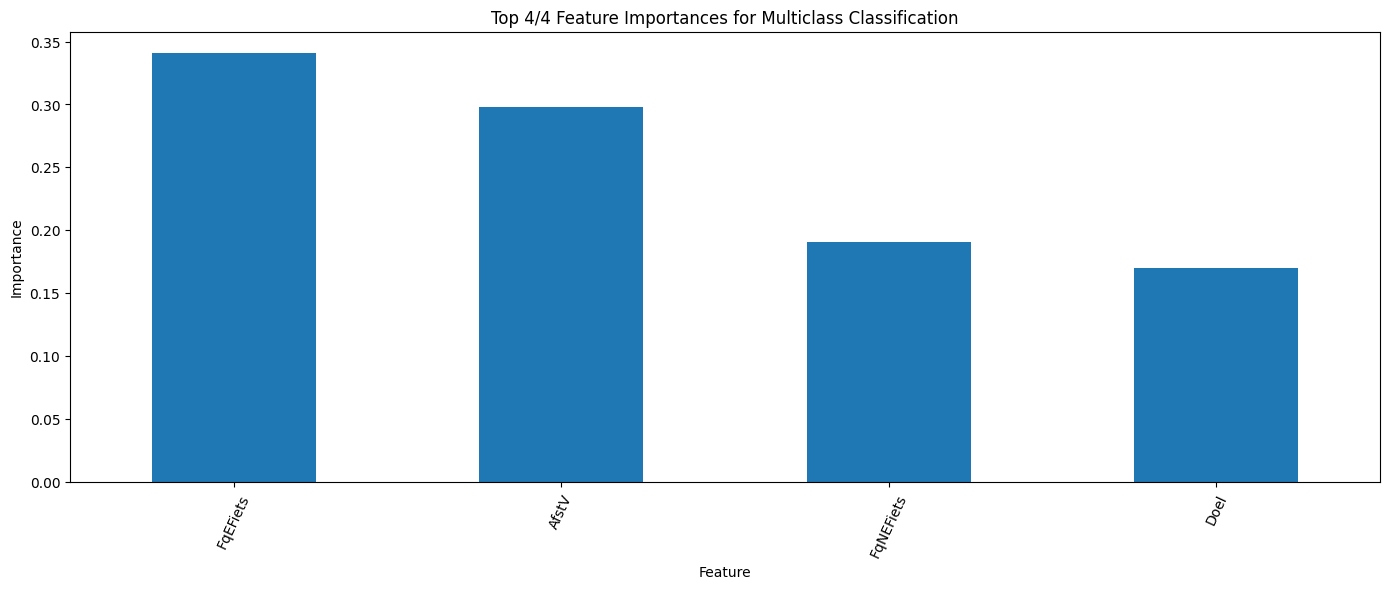

Keeping 5 columns after dropping 197 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.86      0.61      0.71     57177
    Electric bicycle       0.37      0.86      0.52      8774
Non-electric bicycle       0.57      0.78      0.66     27030
             On foot       0.61      0.50      0.55     28067

            accuracy                           0.64    121048
           macro avg       0.60      0.69      0.61    121048
        weighted avg       0.70      0.64      0.65    121048



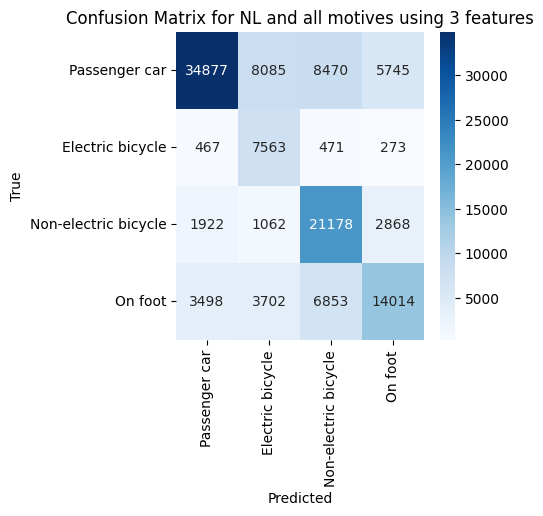

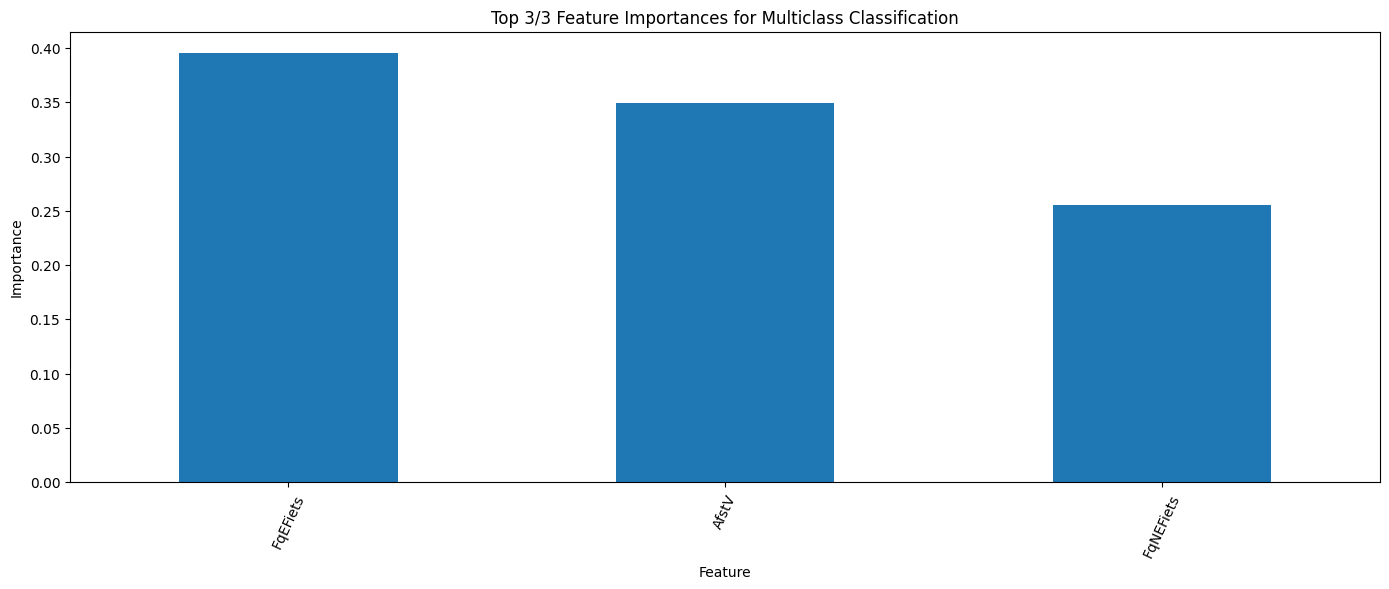

Keeping 4 columns after dropping 198 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.80      0.56      0.66     57177
    Electric bicycle       0.35      0.88      0.50      8774
Non-electric bicycle       0.40      0.65      0.50     27030
             On foot       0.68      0.38      0.49     28067

            accuracy                           0.56    121048
           macro avg       0.56      0.62      0.54    121048
        weighted avg       0.65      0.56      0.57    121048



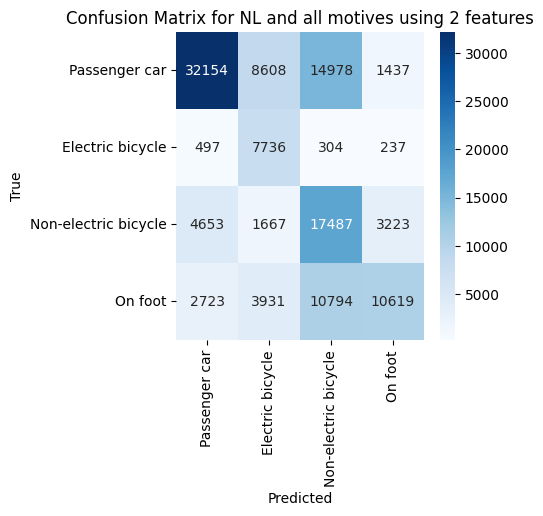

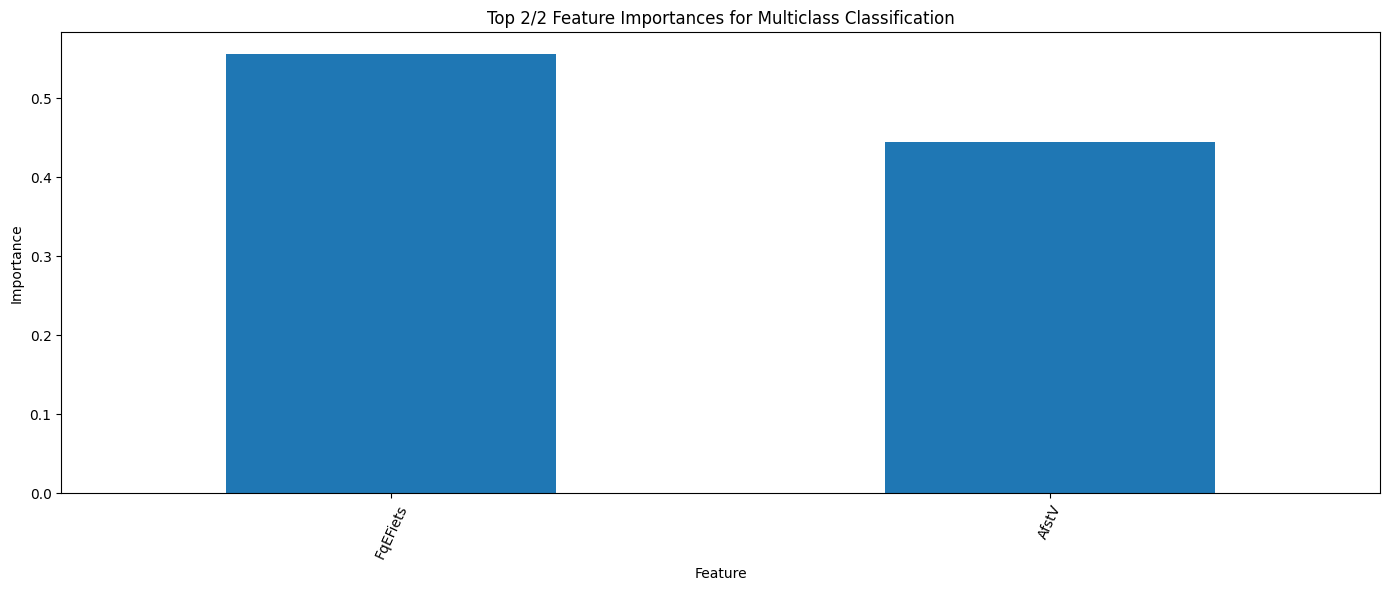

Keeping 3 columns after dropping 199 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'AfstV'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set

                      precision    recall  f1-score   support

       Passenger car       0.56      0.12      0.20     57177
    Electric bicycle       0.31      0.92      0.47      8774
Non-electric bicycle       0.28      0.85      0.42     27030
             On foot       0.00      0.00      0.00     28067

            accuracy                           0.31    121048
           macro avg       0.29      0.47      0.27    121048
        weighted avg       0.35      0.31      0.22    121048



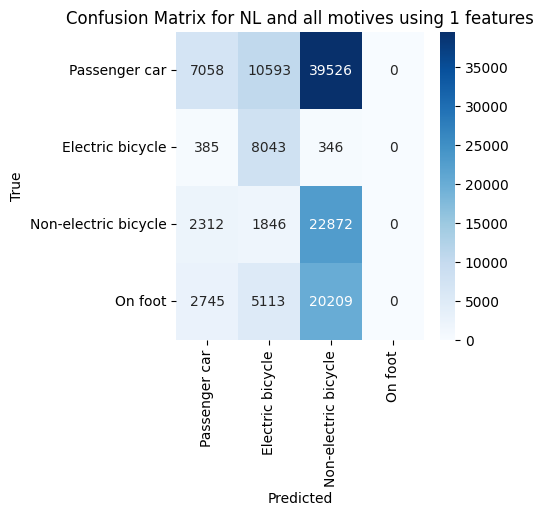

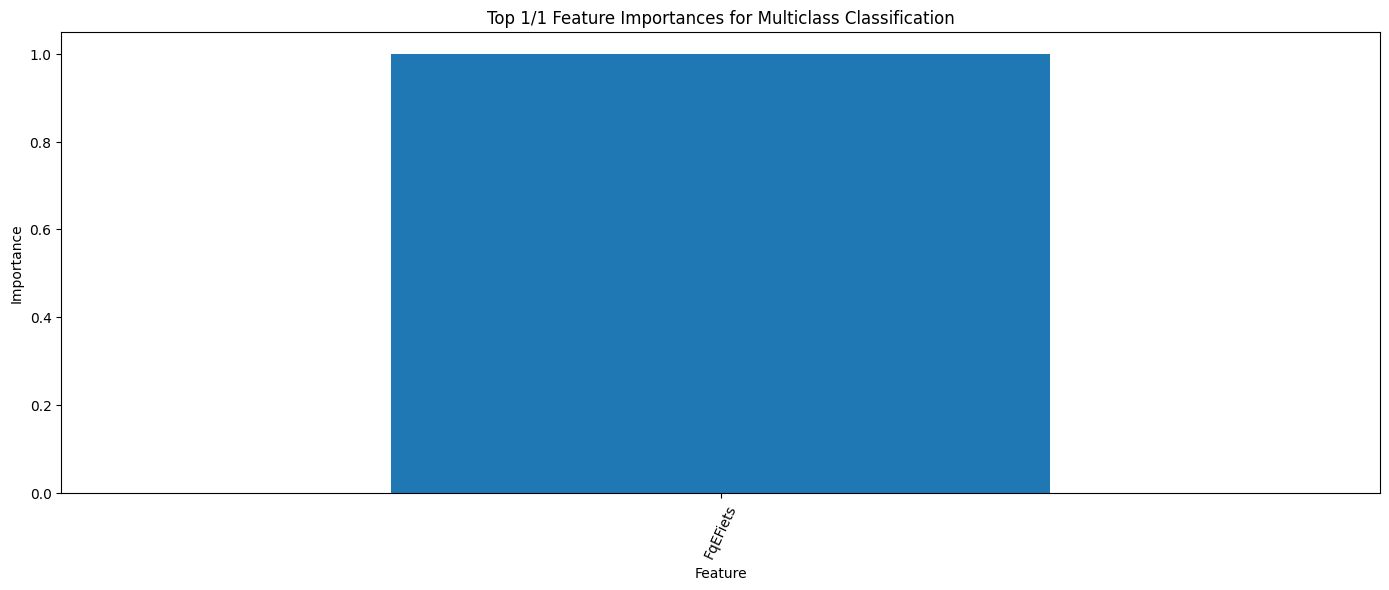

In [26]:
prev_grouped_importances = grouped_importances_less

nums = [200, 100, 50, 25, 15, 10, 8, 5, 4, 3, 2, 1]
accs = []

for num_keep in nums:
    prev_grouped_importances = prev_grouped_importances.sort_values(ascending=False)[:num_keep]

    cols_to_drop = [col for col in df_less_vehicles.columns if col not in list(prev_grouped_importances.index) + [transport_mode_col, id_col]]
    df_keep_loop = df_less_vehicles.drop(columns=cols_to_drop)
    print(f"Keeping {len(df_keep_loop.columns)} columns after dropping {len(cols_to_drop)} columns.")

    pipeline_keep_loop, (X_train, _, _, _), accuracy = run_multiclass_classification(
        df_keep_loop,
        test_size=0.2,
        destinations=None,
        origins=origins,
        location_level=location_level,
        categorical_features=categorical_cols,
        motives=motives,
        plot=True,
        savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles_{num_keep}",
        plot_title=f"Confusion Matrix for {origin_str} and {motive_str} using {num_keep} features",
        verbose=True,
    )

    prev_grouped_importances = get_feature_importances(
        pipeline_keep_loop.steps[1][1].feature_importances_, 
        column_names=X_train.columns, 
        top_n_for_plot=40, 
        savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles_{num_keep}.png"
    )
    accs.append(accuracy)

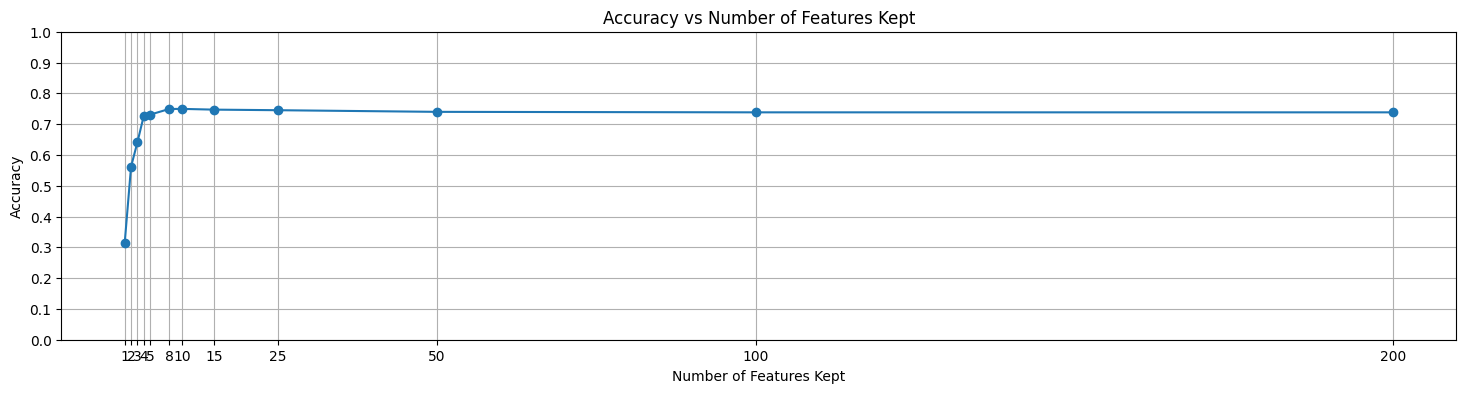

In [14]:
plt.figure(figsize=(18, 4))
plt.plot(nums, accs, marker='o')
plt.title("Accuracy vs Number of Features Kept")
plt.xlabel("Number of Features Kept")
plt.ylabel("Accuracy")
# plt.xscale('log')
plt.xticks(nums)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.savefig("graphics/classification_results/multiclass/accuracy_vs_num_features.png", dpi=300)
plt.show()

In [15]:
nums

[200, 100, 50, 25, 15, 10, 8, 5, 4, 3, 2, 1]

Common labels: [1. 7. 8. 9.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.88      0.61      0.73     57177
    Electric bicycle       0.17      0.56      0.27      8774
Non-electric bicycle       0.51      0.52      0.52     27030
             On foot       0.79      0.72      0.75     28067

            accuracy                           0.62    121048
           macro avg       0.59      0.61      0.57    121048
        weighted avg       0.73      0.62      0.65    121048



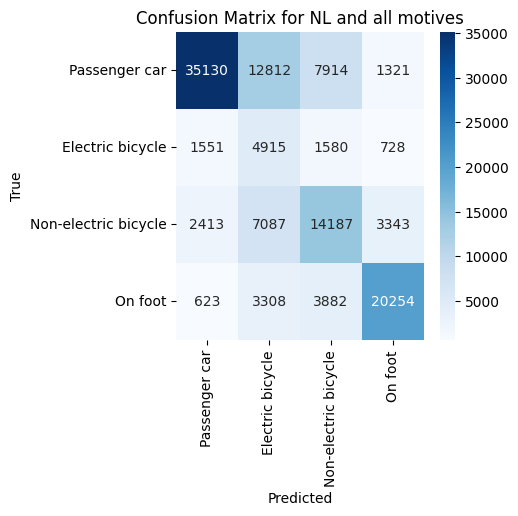

In [16]:

categorical_cols_for_small = [
    urbanness_col, 
    age_col,
    distance_col,
    motive_col,
    "KAfstV",
    "Doel"
]

cols_to_keep = categorical_cols_for_small + [id_col]
cols_to_drop = [col for col in df_less_vehicles.columns if col not in cols_to_keep + [transport_mode_col]]

pipeline_transferable, (X_train, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    drop_cols=cols_to_drop,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/transferable",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

In [17]:
pipeline_transferable.predict_proba(X_train)[:5]

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.2s finished


array([[0.15675408, 0.20055642, 0.5539262 , 0.0887633 ],
       [0.16924278, 0.20498795, 0.53913326, 0.086636  ],
       [0.2674146 , 0.22142688, 0.42807407, 0.08308444],
       [0.24574235, 0.23035742, 0.44421316, 0.07968707],
       [0.1263536 , 0.17189852, 0.53491646, 0.16683142]])